# Part 5: Model Insights Using Classification Models

## Custom Functions/Package

Previously used local modules, but changing to using dojo_ds versions as of 01/22/24 & dojo_ds v1.0

In [1]:
# Importing custom function for project
%load_ext autoreload
%autoreload 2
import project_functions as pf

In [2]:
!pip install -U dojo_ds -q
import dojo_ds as ds
ds.__version__

'1.0.0'

## Loading the Data

In [3]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm

In [4]:
from sklearn import set_config
set_config(transform_output='pandas')

In [5]:
# # plt.style.use('fivethirtyeight')

# import matplotlib.pyplot as plt

# fav_style = ('ggplot','fivethirtyeight')#,'tableau-colorblind10')
# fav_context  ={'context':'notebook', 'font_scale':1.1}
# plt.style.use(fav_style)
# sns.set_context(**fav_context)
# plt.rcParams['savefig.transparent'] = False
# plt.rcParams['savefig.bbox'] = 'tight'

# plt.plot([1,2,3],[2,5,6]);

In [6]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [7]:
## Checking what data we already in our Data folder using os.listdir
import os
FOLDER = 'Data/'
# file_list = sorted(os.listdir(FOLDER))
# file_list

In [8]:
df = pd.read_csv(FOLDER+'combined_tmdb_api_data.csv.gz',lineterminator='\n')
df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,Release Year
0,False,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127,tt0113026,en,The Fantasticks,Two rural teens sing and dance their way throu...,2.559,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0,86,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,False,5.500,22,NaN,2000.0
1,False,NaN,NaN,0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977,tt0113092,en,For the Cause,Earth is in a state of constant war and two co...,3.393,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0,100,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,False,4.958,12,NaN,2000.0
2,False,/krEZg9tb6blhc7sV6Us2ZGQ0gA.jpg,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869,tt0116391,hi,Gang,"After falling prey to underworld, four friends...",2.748,/dYcuiiBDpPUvCcPbiWdH4REjGn3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0,165,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,False,5.000,2,NaN,2000.0
3,False,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843,tt0118694,cn,花樣年華,Two neighbors become intimate after discoverin...,27.940,/iYypPT4bhqXfq1b6EnmxvRt6b2Y.jpg,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2000-09-29,14204632,99,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,False,8.109,2433,PG,2000.0
4,False,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511,tt0118852,en,Chinese Coffee,"When Harry Levine, an aging, unsuccessful Gree...",5.495,/nZGWnSuf1FIuzyEuMRZHHZWViAp.jpg,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-02,0,99,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,False,6.600,56,R,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93054,False,/dyQvD0BDlWk187fDBmJTU2uUVGH.jpg,NaN,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",https://www.todiealonefilm.com,1167732,tt8736506,en,To Die Alone,After suffering a terrible injury while hiking...,5.474,/d7rHwkRlCHhVGBTQQkvGALeC5oz.jpg,"[{'id': 114245, 'logo_path': None, 'name': 'Gl...","[{'iso_3166_1': 'US', 'name': 'United States o...",2024-02-10,0,84,"[{'english_name': 'English', 'iso_639_1': 'en'...",In Production,NaN,To Die Alone,False,0.000,0,NR,2024.0
93055,False,NaN,NaN,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",NaN,560016,tt9214772,en,Monkey Man,An unlikely hero emerges from prison to take o...,7.925,NaN,"[{'id': 3528, 'logo_path': '/cCzCClIzIh81Fa79h...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2024-01-22,0,0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Post Production,NaN,Monkey Man,False,0.000,0,NaN,2024.0
93056,False,NaN,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,1163894,tt9357860,en,The Hopeful,Aboard a steamship sailing across the Atlantic...,2.594,/9zRA1Vefx1gJdt6fKPDt4JJ6FGC.jpg,"[{'id': 206035, 'logo_path': None, 'name': 'Ad...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2024-02-14,0,90,"[{'english_name': 'English', 'iso_639_1': 'en'...",Post Production,The end of the world i

# Preprocessing

In [9]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', 'status',
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,adult,belongs_to_collection,budget,genres,imdb_id,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Release Year
0,False,NaN,10000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",tt0113026,2.559,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0,86,The Fantasticks,5.500,22,NaN,2000.0
1,False,NaN,0,"[{'id': 878, 'name': 'Science Fiction'}]",tt0113092,3.393,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0,100,For the Cause,4.958,12,NaN,2000.0
2,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",tt0116391,2.748,[],2000-04-14,0,165,Gang,5.000,2,NaN,2000.0
3,False,NaN,150000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",tt0118694,27.940,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,14204632,99,In the Mood for Love,8.109,2433,PG,2000.0
4,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",tt0118852,5.495,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0,99,Chinese Coffee,6.600,56,R,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93054,False,NaN,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt8736506,5.474,"[{'id': 114245, 'logo_path': None, 'name': 'Gl...",2024-02-10,0,84,To Die Alone,0.000,0,NR,2024.0
93055,False,NaN,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt9214772,7.925,"[{'id': 3528, 'logo_path': '/cCzCClIzIh81Fa79h...",2024-01-22,0,0,Monkey Man,0.000,0,NaN,2024.0
93056,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",tt9357860,2.594,"[{'id': 206035, 'logo_path': None, 'name': 'Ad...",2024-02-14,0,90,The Hopeful,0.000,0,NaN,2024.0
93057,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",tt9680562,4.889,"[{'id': 209731, 'logo_path': None, 'name': 'Sa...",2024-01-05,0,145,Satyashodhak,0.000,0,NaN,2024.0


## Dropping Movies without Financial Data

In [10]:
filter_finances = (df['revenue']>0) & (df['budget']>0)
filter_finances.sum()

6153

In [11]:
df = df[filter_finances]
df

,adult,belongs_to_collection,budget,genres,imdb_id,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Release Year
3,False,NaN,150000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",tt0118694,27.940,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,14204632,99,In the Mood for Love,8.109,2433,PG,2000.0
12,False,NaN,120000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",tt0120467,7.887,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",2002-04-26,14904,87,Vulgar,5.444,45,R,2002.0
14,False,"{'id': 718551, 'name': 'Chicken Run Collection...",45000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",tt0120630,91.080,"[{'id': 297, 'logo_path': '/58TnhYZqbMYgkHM6lg...",2000-06-23,224834564,84,Chicken Run,6.800,4704,G,2000.0
17,False,NaN,8000000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",tt0120753,11.473,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",2000-02-09,105983,122,The Million Dollar Hotel,5.893,303,R,2000.0
18,False,"{'id': 87359, 'name': 'Mission: Impossible Col...",125000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",tt0120755,43.305,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",2000-05-24,546400000,123,Mission: Impossible II,6.123,6299,NaN,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92808,False,NaN,36000000,"[{'id': 35, 'name': 'Comedy'}]",tt11762114,276.559,"[{'id': 26402, 'logo_path': '/1BFbFgEhD1tJShFT...",2024-01-10,33200000,113,Mean Girls,6.800,53,PG-13,2024.0
92833,False,NaN,24066000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",tt14564000,40.886,"[{'id': 69898, 'logo_path': '/bvPo07eG1gz3r6OC...",2024-01-11,15323439,159,Guntur Kaaram,6.000,3,NaN,2024.0
92961,False,NaN,1000,"[{'id': 27, 'name': 'Horror'}, {'id': 99, 'nam...",tt28630947,1.004,"[{'id': 209845, 'logo_path': None, 'name': 'Cr...",2023-01-10,100,58,The haunting in rosemary lane,0.000,0,NaN,2023.0
93025,False,NaN,5,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",tt30828956,2.127,"[{'id': 157524, 'logo_path': None, 'name': 'Ma...",2024-01-31,4,117,The bigfoot prophecy,0.000,0,NR,2024.0


### Check Duplicates

In [12]:
df.duplicated(subset=['imdb_id']).sum()

0

### Set Index - tmdb_id 

In [13]:
df = df.set_index('imdb_id')
df

,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Release Year
imdb_id,,,,,,,,,,,,,,
tt0118694,False,NaN,150000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",27.940,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,14204632,99,In the Mood for Love,8.109,2433,PG,2000.0
tt0120467,False,NaN,120000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",7.887,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",2002-04-26,14904,87,Vulgar,5.444,45,R,2002.0
tt0120630,False,"{'id': 718551, 'name': 'Chicken Run Collection...",45000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",91.080,"[{'id': 297, 'logo_path': '/58TnhYZqbMYgkHM6lg...",2000-06-23,224834564,84,Chicken Run,6.800,4704,G,2000.0
tt0120753,False,NaN,8000000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",11.473,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",2000-02-09,105983,122,The Million Dollar Hotel,5.893,303,R,2000.0
tt0120755,False,"{'id': 87359, 'name': 'Mission: Impossible Col...",125000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",43.305,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",2000-05-24,546400000,123,Mission: Impossible II,6.123,6299,NaN,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt11762114,False,NaN,36000000,"[{'id': 35, 'name': 'Comedy'}]",276.559,"[{'id': 26402, 'logo_path': '/1BFbFgEhD1tJShFT...",2024-01-10,33200000,113,Mean Girls,6.800,53,PG-13,2024.0
tt14564000,False,NaN,24066000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",40.886,"[{'id': 69898, 'logo_path': '/bvPo07eG1gz3r6OC...",2024-01-11,15323439,159,Guntur Kaaram,6.000,3,NaN,2024.0
tt28630947,False,NaN,1000,"[{'id': 27, 'name': 'Horror'}, {'id': 99, 'nam...",1.004,"[{'id': 209845, 'logo_path': None, 'name': 'Cr...",2023-01-10,100,58,The haunting in rosemary lane,0.000,0,NaN,2023.0


## Feature Engineering


- Collection: convert to boolean
- Genres: get just name and OHE
- Cleaning Certification
- Converting release date to year, month, and day.

#### belongs to collection

In [14]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

1366

In [15]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    4787
True     1366
Name: belongs_to_collection, dtype: int64

#### Converting year to sep features

In [16]:
df['release_date'] = pd.to_datetime(df['release_date'])

In [17]:
df['DayofWeek'] = df['release_date'].dt.day_name()
df['MonthName'] = df['release_date'].dt.month_name()
df['Month'] = df['release_date'].dt.month

df['YearReleased'] = df['release_date'].dt.year

In [18]:
df

,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased
imdb_id,,,,,,,,,,,,,,,,,,
tt0118694,False,False,150000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",27.940,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",2000-09-29,14204632,99,In the Mood for Love,8.109,2433,PG,2000.0,Friday,September,9.0,2000.0
tt0120467,False,False,120000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",7.887,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",2002-04-26,14904,87,Vulgar,5.444,45,R,2002.0,Friday,April,4.0,2002.0
tt0120630,False,True,45000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",91.080,"[{'id': 297, 'logo_path': '/58TnhYZqbMYgkHM6lg...",2000-06-23,224834564,84,Chicken Run,6.800,4704,G,2000.0,Friday,June,6.0,2000.0
tt0120753,False,False,8000000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",11.473,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",2000-02-09,105983,122,The Million Dollar Hotel,5.893,303,R,2000.0,Wednesday,February,2.0,2000.0
tt0120755,False,True,125000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",43.305,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",2000-05-24,546400000,123,Mission: Impossible II,6.123,6299,NaN,2000.0,Wednesday,May,5.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt11762114,False,False,36000000,"[{'id': 35, 'name': 'Comedy'}]",276.559,"[{'id': 26402, 'logo_path': '/1BFbFgEhD1tJShFT...",2024-01-10,33200000,113,Mean Girls,6.800,53,PG-13,2024.0,Wednesday,January,1.0,2024.0
tt14564000,False,False,24066000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",40.886,"[{'id': 69898, 'logo_path': '/bvPo07eG1gz3r6OC...",2024-01-11,15323439,159,Guntur Kaaram,6.000,3,NaN,2024.0,Thursday,January,1.0,2024.0
tt28630947,False,False,1000,"[{'id': 27, 'name': 'Horror'}, {'id': 99, 'nam...",1.004,"[{'id': 209845, 'logo_path': None, 'name': 'Cr...",2023-01-10,100,58,The haunting in rosemary lane,0.000,0,NaN,2023.0,Tuesday,January,1.0,2023.0


In [19]:
# ## split release date into 3 columns
# new_cols = ['year','month','day']
# df[new_cols] = df['release_date'].str.split('-',expand=True)
# df[new_cols] = df[new_cols].astype(float)
# ## drop original feature
df = df.drop(columns=['release_date'])
df

,adult,belongs_to_collection,budget,genres,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased
imdb_id,,,,,,,,,,,,,,,,,
tt0118694,False,False,150000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",27.940,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",14204632,99,In the Mood for Love,8.109,2433,PG,2000.0,Friday,September,9.0,2000.0
tt0120467,False,False,120000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",7.887,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",14904,87,Vulgar,5.444,45,R,2002.0,Friday,April,4.0,2002.0
tt0120630,False,True,45000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",91.080,"[{'id': 297, 'logo_path': '/58TnhYZqbMYgkHM6lg...",224834564,84,Chicken Run,6.800,4704,G,2000.0,Friday,June,6.0,2000.0
tt0120753,False,False,8000000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",11.473,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",105983,122,The Million Dollar Hotel,5.893,303,R,2000.0,Wednesday,February,2.0,2000.0
tt0120755,False,True,125000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",43.305,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",546400000,123,Mission: Impossible II,6.123,6299,NaN,2000.0,Wednesday,May,5.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt11762114,False,False,36000000,"[{'id': 35, 'name': 'Comedy'}]",276.559,"[{'id': 26402, 'logo_path': '/1BFbFgEhD1tJShFT...",33200000,113,Mean Girls,6.800,53,PG-13,2024.0,Wednesday,January,1.0,2024.0
tt14564000,False,False,24066000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",40.886,"[{'id': 69898, 'logo_path': '/bvPo07eG1gz3r6OC...",15323439,159,Guntur Kaaram,6.000,3,NaN,2024.0,Thursday,January,1.0,2024.0
tt28630947,False,False,1000,"[{'id': 27, 'name': 'Horror'}, {'id': 99, 'nam...",1.004,"[{'id': 209845, 'logo_path': None, 'name': 'Cr...",100,58,The haunting in rosemary lane,0.000,0,NaN,2023.0,Tuesday,January,1.0,2023.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6153 entries, tt0118694 to tt9682428
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  6153 non-null   bool   
 1   belongs_to_collection  6153 non-null   bool   
 2   budget                 6153 non-null   int64  
 3   genres                 6153 non-null   object 
 4   popularity             6153 non-null   float64
 5   production_companies   6153 non-null   object 
 6   revenue                6153 non-null   int64  
 7   runtime                6153 non-null   int64  
 8   title                  6153 non-null   object 
 9   vote_average           6153 non-null   float64
 10  vote_count             6153 non-null   int64  
 11  certification          4142 non-null   object 
 12  Release Year           6138 non-null   float64
 13  DayofWeek              6138 non-null   object 
 14  MonthName              6138 non-null   object 
 

#### genre

In [21]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [22]:
## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

,adult,belongs_to_collection,budget,genres,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased,genres_list
imdb_id,,,,,,,,,,,,,,,,,,
tt0118694,False,False,150000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",27.940,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",14204632,99,In the Mood for Love,8.109,2433,PG,2000.0,Friday,September,9.0,2000.0,Drama
tt0118694,False,False,150000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",27.940,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",14204632,99,In the Mood for Love,8.109,2433,PG,2000.0,Friday,September,9.0,2000.0,Romance
tt0120467,False,False,120000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",7.887,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",14904,87,Vulgar,5.444,45,R,2002.0,Friday,April,4.0,2002.0,Drama
tt0120467,False,False,120000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",7.887,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",14904,87,Vulgar,5.444,45,R,2002.0,Friday,April,4.0,2002.0,Horror
tt0120467,False,False,120000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",7.887,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",14904,87,Vulgar,5.444,45,R,2002.0,Friday,April,4.0,2002.0,Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt30828956,False,False,5,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2.127,"[{'id': 157524, 'logo_path': None, 'name': 'Ma...",4,117,The bigfoot prophecy,0.000,0,NR,2024.0,Wednesday,January,1.0,2024.0,Adventure
tt30828956,False,False,5,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2.127,"[{'id': 157524, 'logo_path': None, 'name': 'Ma...",4,117,The bigfoot prophecy,0.000,0,NR,2024.0,Wednesday,January,1.0,2024.0,Fantasy
tt30828956,False,False,5,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2.127,"[{'id': 157524, 'logo_path': None, 'name': 'Ma...",4,117,The bigfoot prophecy,0.000,0,NR,2024.0,Wednesday,January,1.0,2024.0,Horror


In [23]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    

## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df

,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased,Genre_Drama,Genre_Romance,Genre_Horror,Genre_Thriller,Genre_Crime,Genre_Animation,Genre_Comedy,Genre_Family,Genre_Adventure,Genre_Action,Genre_Science Fiction,Genre_Fantasy,Genre_Mystery,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,Genre_TV Movie
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0118694,False,False,150000,27.940,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",14204632,99,In the Mood for Love,8.109,2433,PG,2000.0,Friday,September,9.0,2000.0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0120467,False,False,120000,7.887,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",14904,87,Vulgar,5.444,45,R,2002.0,Friday,April,4.0,2002.0,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0120630,False,True,45000000,91.080,"[{'id': 297, 'logo_path': '/58TnhYZqbMYgkHM6lg...",224834564,84,Chicken Run,6.800,4704,G,2000.0,Friday,June,6.0,2000.0,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
tt0120753,False,False,8000000,11.473,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",105983,122,The Million Dollar Hotel,5.893,303,R,2000.0,Wednesday,February,2.0,2000.0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0120755,False,True,125000000,43.305,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",546400000,123,Mission: Impossible II,6.123,6299,NaN,2000.0,Wednesday,May,5.0,2000.0,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt11762114,False,False,36000000,276.559,"[{'id': 26402, 'logo_path': '/1BFbFgEhD1tJShFT...",33200000,113,Mean Girls,6.800,53,PG-13,2024.0,Wednesday,January,1.0,2024.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
tt14564000,False,False,24066000,40.886,"[{'id': 69898, 'logo_path': '/bvPo07eG1gz3r6OC...",15323439,159,Guntur Kaaram,6.000,3,NaN,2024.0,Thursday,January,1.0,2024.0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
tt28630947,False,False,1000,1.004,"[{'id': 209845, 'logo_path': None, 'name': 'Cr...",100,58,The haunting in rosemary lane,0.000,0,NaN,2023.0,Tuesday,January,1.0,2023.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


#### certification

In [24]:
## Checking Certification values
# df['certification'].value_counts(dropna=False)

# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

NaN      2011
R        1755
PG-13    1475
PG        597
NR        203
G          95
NC-17      17
Name: certification, dtype: int64

### Production Company

In [25]:
df['production_companies']

imdb_id
tt0118694     [{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...
tt0120467     [{'id': 102045, 'logo_path': None, 'name': 'Ch...
tt0120630     [{'id': 297, 'logo_path': '/58TnhYZqbMYgkHM6lg...
tt0120753     [{'id': 1490, 'logo_path': None, 'name': 'Kint...
tt0120755     [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...
                                    ...                        
tt11762114    [{'id': 26402, 'logo_path': '/1BFbFgEhD1tJShFT...
tt14564000    [{'id': 69898, 'logo_path': '/bvPo07eG1gz3r6OC...
tt28630947    [{'id': 209845, 'logo_path': None, 'name': 'Cr...
tt30828956    [{'id': 157524, 'logo_path': None, 'name': 'Ma...
tt9682428     [{'id': 76907, 'logo_path': '/ygMQtjsKX7BZkCQh...
Name: production_companies, Length: 6153, dtype: object

In [26]:
## getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()
idxmax 

'tt1816518'

In [27]:
test = df.loc[idxmax, 'production_companies']
test

'[{\'id\': 6973, \'logo_path\': None, \'name\': \'Les Armateurs\', \'origin_country\': \'FR\'}, {\'id\': 27350, \'logo_path\': None, \'name\': \'Maybe Movies\', \'origin_country\': \'FR\'}, {\'id\': 694, \'logo_path\': \'/5LEHONGkZBIoWvp1ygHOF8iyi1M.png\', \'name\': \'StudioCanal\', \'origin_country\': \'FR\'}, {\'id\': 591, \'logo_path\': \'/q5I5RDwMEiqoNmfaJgd2LraEOJY.png\', \'name\': \'France 3 Cinéma\', \'origin_country\': \'FR\'}, {\'id\': 2565, \'logo_path\': \'/i7ecMuPlAvNJjg9Rp26gJWzeEmu.png\', \'name\': \'La Parti Production\', \'origin_country\': \'BE\'}, {\'id\': 13351, \'logo_path\': \'/sj74baixfiB8uIdTJWzU26E25ef.png\', \'name\': \'Melusine Productions\', \'origin_country\': \'LU\'}, {\'id\': 792, \'logo_path\': \'/cRhBQP1FFNugNxKkO1pUgeD2Rkr.png\', \'name\': \'RTBF\', \'origin_country\': \'BE\'}, {\'id\': 104, \'logo_path\': \'/9aotxauvc9685tq9pTcRJszuT06.png\', \'name\': \'Canal+\', \'origin_country\': \'FR\'}, {\'id\': 10611, \'logo_path\': \'/zQ4fGaEnNkWfSzyygXRcUZwPmD

In [28]:
# using regular expressions to extrap just the name
import re
exp= r"\'name\'\:.?\'(\w*.*?)\'"
re.findall(exp, test)

['Les Armateurs',
 'Maybe Movies',
 'StudioCanal',
 'France 3 Cinéma',
 'La Parti Production',
 'Melusine Productions',
 'RTBF',
 'Canal+',
 'Ciné+',
 'France Télévisions',
 'Eurimages',
 'MEDIA Programme of the European Union',
 'CNC',
 'La Région Île-de-France',
 'Pôle Image Magelis',
 'Département de la Charente',
 'Région Poitou-Charentes',
 'PROCIREP',
 'Angoa-Agicoa',
 'VOO',
 'Région Wallonne',
 'Tax Shelter du Gouvernement Fédéral Belge',
 'Casa Kafka Pictures',
 'Dexia',
 'Film Fund Luxembourg']

In [29]:
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies

In [30]:
## test function
get_prod_company_names(test)

['Les Armateurs',
 'Maybe Movies',
 'StudioCanal',
 'France 3 Cinéma',
 'La Parti Production',
 'Melusine Productions',
 'RTBF',
 'Canal+',
 'Ciné+',
 'France Télévisions',
 'Eurimages',
 'MEDIA Programme of the European Union',
 'CNC',
 'La Région Île-de-France',
 'Pôle Image Magelis',
 'Département de la Charente',
 'Région Poitou-Charentes',
 'PROCIREP',
 'Angoa-Agicoa',
 'VOO',
 'Région Wallonne',
 'Tax Shelter du Gouvernement Fédéral Belge',
 'Casa Kafka Pictures',
 'Dexia',
 'Film Fund Luxembourg']

In [31]:
## Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()
prod_companies.value_counts().head(49)

Universal Pictures           322
Warner Bros. Pictures        295
Columbia Pictures            265
Paramount                    216
20th Century Fox             213
MISSING                      190
Canal+                       168
Lionsgate                    157
New Line Cinema              157
Walt Disney Pictures         149
Relativity Media             126
StudioCanal                  119
Summit Entertainment         110
Metro-Goldwyn-Mayer          103
DreamWorks Pictures          102
Village Roadshow Pictures     93
Focus Features                92
Miramax                       88
Screen Gems                   82
Touchstone Pictures           72
Fox Searchlight Pictures      70
Film4 Productions             69
Dune Entertainment            68
Working Title Films           68
Blumhouse Productions         67
TSG Entertainment             67
Regency Enterprises           65
France 2 Cinéma               62
Millennium Media              60
Dimension Films               59
Ingenious 

In [32]:
prod_companies.nunique()

7815

In [33]:
# df['prod_company'].nunique()

- Common Prod Company Encoding:
    - Keep top 50 most common companies an one hot encode

In [34]:
## saving the 50 most common companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'ARTE France Cinéma',
 'BBC Film',
 'Blumhouse Productions',
 'CNC',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'EuropaCorp',
 'Film i Väst',
 'Film4 Productions',
 'FilmNation Entertainment',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Mandate International',
 'Metro-Goldwyn-Mayer',
 'Millennium Media',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Pathé',
 'Regency Enterprises',
 'Relativity Media',
 'Scott Free Productions',
 'Scott Rudin Productions',
 'Screen Gems',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney Pictures',
 'Warner Bros. Pictures',
 'Wild Bun

In [35]:
## manually ohe top 20 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

In [36]:
df = df.drop(columns=['production_companies','prod_company'])

### Saving Lists of Engineering OHE Cols

In [37]:
## Saving list of one hot encoded feature to easily dorp

genre_cols = list(filter(lambda x: x.startswith('Genre'),df.columns))
prod_comp_cols = list(filter(lambda x: x.startswith('ProdC'),df.columns))

genre_cols,prod_comp_cols

(['Genre_Drama',
  'Genre_Romance',
  'Genre_Horror',
  'Genre_Thriller',
  'Genre_Crime',
  'Genre_Animation',
  'Genre_Comedy',
  'Genre_Family',
  'Genre_Adventure',
  'Genre_Action',
  'Genre_Science Fiction',
  'Genre_Fantasy',
  'Genre_Mystery',
  'Genre_War',
  'Genre_History',
  'Genre_Music',
  'Genre_Western',
  'Genre_Documentary',
  'Genre_TV Movie'],
 ['ProdComp_20th Century Fox',
  'ProdComp_ARTE France Cinéma',
  'ProdComp_BBC Film',
  'ProdComp_Blumhouse Productions',
  'ProdComp_CNC',
  'ProdComp_Canal+',
  'ProdComp_Ciné+',
  'ProdComp_Columbia Pictures',
  'ProdComp_Dimension Films',
  'ProdComp_DreamWorks Pictures',
  'ProdComp_Dune Entertainment',
  'ProdComp_EuropaCorp',
  'ProdComp_Film i Väst',
  'ProdComp_Film4 Productions',
  'ProdComp_FilmNation Entertainment',
  'ProdComp_Focus Features',
  'ProdComp_Fox 2000 Pictures',
  'ProdComp_Fox Searchlight Pictures',
  'ProdComp_France 2 Cinéma',
  'ProdComp_France 3 Cinéma',
  'ProdComp_Ingenious Media',
  'ProdComp

## Defining "Successful"

- Want to use ROI but need to be careful about movies with 0's for budget or revenue

In [38]:
# ## Dropping rows with 0's for budget and revenue
# df = df[~(df['revenue']==0) & ~(df['budget']==0)]
# df

<Axes: xlabel='budget', ylabel='Count'>

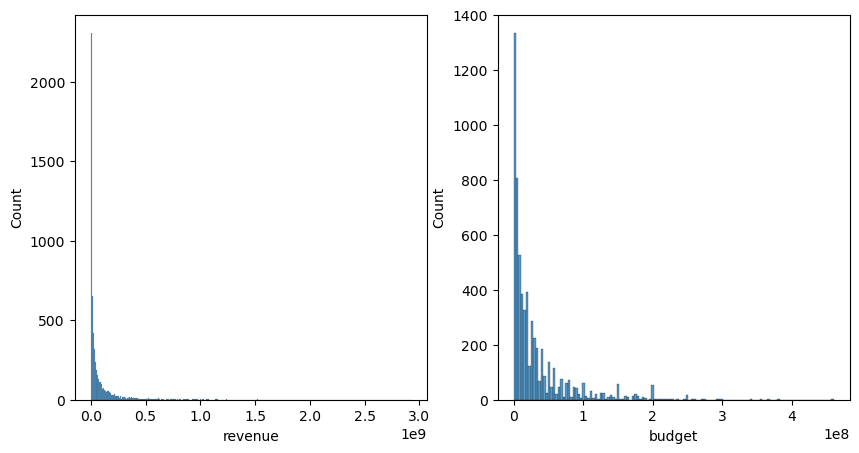

In [39]:
fig,axes = plt.subplots(ncols=2, figsize=(10,5))
sns.histplot(data=df, x='revenue', ax=axes[0])
sns.histplot(data=df, x='budget', ax=axes[1])

### Calculating Target

In [40]:
# Calculating Financial Target
df['profit'] = df['revenue'] - df['budget']
df['ROI'] = df['profit']/ df['budget'] *100

In [41]:

df.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,Release Year,Month,YearReleased,profit,ROI
count,6.153000e+03,6153.000000,6.153000e+03,6153.000000,6153.000000,6153.000000,6138.000000,6138.000000,6138.000000,6.153000e+03,6.153000e+03
mean,3.105222e+07,27.603687,8.553828e+07,109.116529,6.294637,1970.464326,2011.366080,6.884816,2011.366080,5.448606e+07,8.583700e+03
std,4.454177e+07,53.681315,1.846379e+08,21.541736,1.198593,3404.284654,6.283722,3.418684,6.283722,1.537355e+08,3.466150e+05
min,1.000000e+00,0.000000,1.000000e+00,0.000000,0.000000,0.000000,2000.000000,1.000000,2000.000000,-1.995460e+08,-9.999990e+01
25%,4.500000e+06,10.337000,2.636637e+06,95.000000,5.845000,141.000000,2006.000000,4.000000,2006.000000,-2.847262e+06,-4.701489e+01
50%,1.500000e+07,17.710000,1.900000e+07,105.000000,6.413000,661.000000,2011.000000,7.000000,2011.000000,4.040871e+06,5.839125e+01
75%,3.700000e+07,29.970000,8.239114e+07,120.000000,6.995000,2169.000000,2016.000000,10.000000,2016.000000,4.716216e+07,2.496088e+02
max,4.600000e+08,2738.782000,2.923706e+09,310.000000,10.000000,35072.000000,2024.000000,12.000000,2024.000000,2.686706e+09,1.666657e+07


<Axes: ylabel='ROI'>

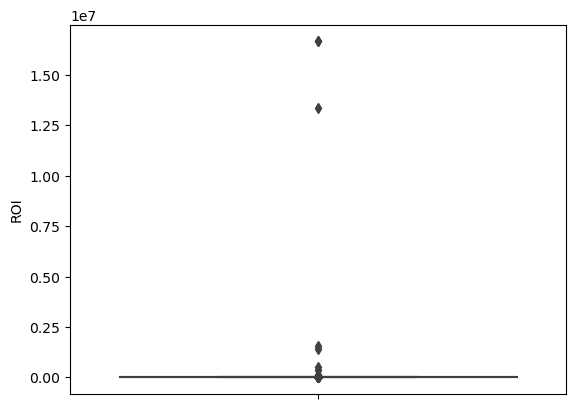

In [42]:
sns.boxplot(data=df, y='ROI')

In [43]:
# Viewing ROI outliers
df[stats.zscore(df['ROI']).abs()>3]

,adult,belongs_to_collection,budget,popularity,revenue,runtime,title,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased,Genre_Drama,Genre_Romance,Genre_Horror,Genre_Thriller,Genre_Crime,Genre_Animation,Genre_Comedy,Genre_Family,Genre_Adventure,Genre_Action,Genre_Science Fiction,Genre_Fantasy,Genre_Mystery,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,Genre_TV Movie,ProdComp_20th Century Fox,ProdComp_ARTE France Cinéma,ProdComp_BBC Film,ProdComp_Blumhouse Productions,ProdComp_CNC,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_EuropaCorp,ProdComp_Film i Väst,ProdComp_Film4 Productions,ProdComp_FilmNation Entertainment,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Mandate International,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Media,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Pathé,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films,profit,ROI
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0404802,False,False,90,12.084,1410778,91,The Notorious Bettie Page,6.345,148,R,2005.0,Wednesday,September,9.0,2005.0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1410688,1.567431e+06
tt6416676,False,False,528,1.957,7436000,96,Jailbait,6.800,8,NaN,2017.0,Friday,April,4.0,2017.0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,7435472,1.408233e+06
tt13925862,False,False,128,1.467,17130489,128,"Dad, I'm Sorry",7.300,6,NR,2021.0,Friday,March,3.0,2021.0,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17130361,1.338309e+07
tt23845954,False,False,30,0.600,5000000,143,Nosce Te Ipsum,0.000,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4999970,1.666657e+07
tt29425073,False,False,30,0.600,5000000,143

In [44]:
df = df[stats.zscore(df['ROI']).abs()<=3]
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,title,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased,Genre_Drama,Genre_Romance,Genre_Horror,Genre_Thriller,Genre_Crime,Genre_Animation,Genre_Comedy,Genre_Family,Genre_Adventure,Genre_Action,Genre_Science Fiction,Genre_Fantasy,Genre_Mystery,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,Genre_TV Movie,ProdComp_20th Century Fox,ProdComp_ARTE France Cinéma,ProdComp_BBC Film,ProdComp_Blumhouse Productions,ProdComp_CNC,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_EuropaCorp,ProdComp_Film i Väst,ProdComp_Film4 Productions,ProdComp_FilmNation Entertainment,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Mandate International,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Media,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Pathé,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films,profit,ROI
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0118694,False,False,150000,27.940,14204632,99,In the Mood for Love,8.109,2433,PG,2000.0,Friday,September,9.0,2000.0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,14054632,9369.754667
tt0120467,False,False,120000,7.887,14904,87,Vulgar,5.444,45,R,2002.0,Friday,April,4.0,2002.0,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-105096,-87.580000
tt0120630,False,True,45000000,91.080,224834564,84,Chicken Run,6.800,4704,G,2000.0,Friday,June,6.0,2000.0,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,179834564,399.632364
tt0120753,False,False,8000000,11.473,105983,122,The Million Dollar Hotel,5.893,303,R,2000.0,Wednesday,February,2.0,2000.0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-7894017,-98.675213
tt0120755,False,True,1250

<Axes: ylabel='ROI'>

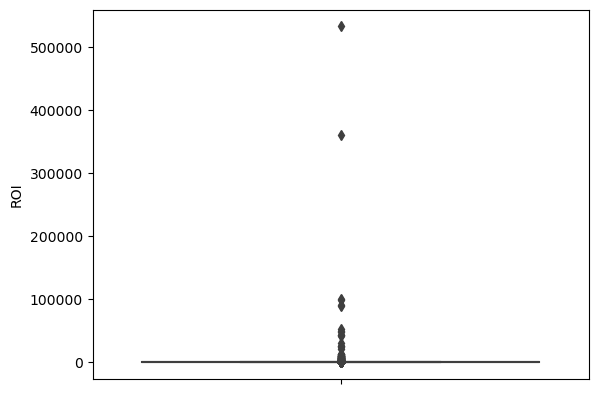

In [45]:
sns.boxplot(data=df, y='ROI')

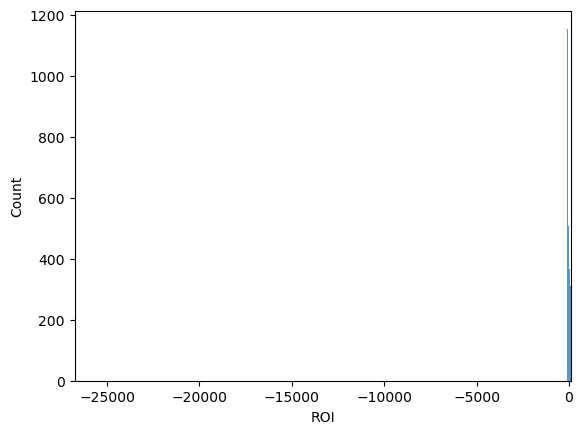

In [46]:
ax = sns.histplot(data=df, x='ROI', )
ax.set_xlim(right=100);

In [47]:
df['successful']  = df['revenue'] > df['budget']#df['ROI'] >0 
df['successful'].value_counts(1)

True     0.619714
False    0.380286
Name: successful, dtype: float64

<Axes: xlabel='successful', ylabel='revenue'>

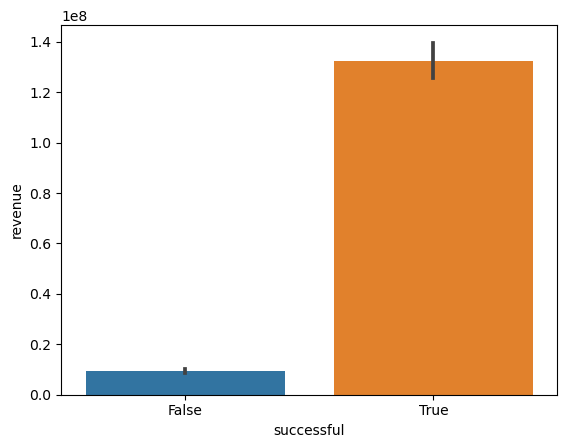

In [48]:
sns.barplot(data=df,x='successful',y='revenue')

In [49]:
df[df['successful']==False]

,adult,belongs_to_collection,budget,popularity,revenue,runtime,title,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased,Genre_Drama,Genre_Romance,Genre_Horror,Genre_Thriller,Genre_Crime,Genre_Animation,Genre_Comedy,Genre_Family,Genre_Adventure,Genre_Action,Genre_Science Fiction,Genre_Fantasy,Genre_Mystery,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,Genre_TV Movie,ProdComp_20th Century Fox,ProdComp_ARTE France Cinéma,ProdComp_BBC Film,ProdComp_Blumhouse Productions,ProdComp_CNC,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_EuropaCorp,ProdComp_Film i Väst,ProdComp_Film4 Productions,ProdComp_FilmNation Entertainment,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Mandate International,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Media,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Pathé,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films,profit,ROI,successful
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0120467,False,False,120000,7.887,14904,87,Vulgar,5.444,45,R,2002.0,Friday,April,4.0,2002.0,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-105096,-87.580000,False
tt0120753,False,False,8000000,11.473,105983,122,The Million Dollar Hotel,5.893,303,R,2000.0,Wednesday,February,2.0,2000.0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-7894017,-98.675213,False
tt0120913,False,False,75000000,18.657,36754634,94,Titan A.E.,6.556,1022,PG,2000.0,Friday,June,6.0,2000.0,False,False,False,False,False,True,False,True,True,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-38245366,-50.993821,False
tt0127349,False,False,8500000,10.865,327418,105,Waking the Dead,6.099,81,R,2000.0,Friday,March,3.0,2000.0,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-8172582,-96.148024,False
tt01

## Train Test Split

In [50]:
drop_for_model = ['title','ROI','revenue','profit']
df_ml = df.drop(columns=drop_for_model)
df_ml

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased,Genre_Drama,Genre_Romance,Genre_Horror,Genre_Thriller,Genre_Crime,Genre_Animation,Genre_Comedy,Genre_Family,Genre_Adventure,Genre_Action,Genre_Science Fiction,Genre_Fantasy,Genre_Mystery,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,Genre_TV Movie,ProdComp_20th Century Fox,ProdComp_ARTE France Cinéma,ProdComp_BBC Film,ProdComp_Blumhouse Productions,ProdComp_CNC,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_EuropaCorp,ProdComp_Film i Väst,ProdComp_Film4 Productions,ProdComp_FilmNation Entertainment,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Mandate International,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Media,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Pathé,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films,successful
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0118694,False,False,150000,27.940,99,8.109,2433,PG,2000.0,Friday,September,9.0,2000.0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
tt0120467,False,False,120000,7.887,87,5.444,45,R,2002.0,Friday,April,4.0,2002.0,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0120630,False,True,45000000,91.080,84,6.800,4704,G,2000.0,Friday,June,6.0,2000.0,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
tt0120753,False,False,8000000,11.473,122,5.893,303,R,2000.0,Wednesday,February,2.0,2000.0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0120755,False,True,125000000,43.305,123,6.123,6299,NaN,2000.0,Wednesday,May,5.0,2000.0,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,Fals

In [51]:
## Make x and y variables
y = df_ml['successful'].copy()
X = df_ml.drop(columns=['successful']).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train.head()

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Release Year,DayofWeek,MonthName,Month,YearReleased,Genre_Drama,Genre_Romance,Genre_Horror,Genre_Thriller,Genre_Crime,Genre_Animation,Genre_Comedy,Genre_Family,Genre_Adventure,Genre_Action,Genre_Science Fiction,Genre_Fantasy,Genre_Mystery,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,Genre_TV Movie,ProdComp_20th Century Fox,ProdComp_ARTE France Cinéma,ProdComp_BBC Film,ProdComp_Blumhouse Productions,ProdComp_CNC,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_EuropaCorp,ProdComp_Film i Väst,ProdComp_Film4 Productions,ProdComp_FilmNation Entertainment,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Mandate International,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Media,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Pathé,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt1013752,False,True,85000000,7.908,107,6.682,6852,PG-13,2009.0,Thursday,April,4.0,2009.0,True,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
tt0854678,False,False,1000000,5.388,106,6.963,200,NaN,2007.0,Monday,April,4.0,2007.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt11138512,False,False,80000000,66.951,137,7.084,3825,R,2022.0,Thursday,April,4.0,2022.0,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt1442576,False,False,9500000,6.111,130,5.580,75,NaN,2010.0,Friday,January,1.0,2010.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt6439020,False,False,15600000,17.578,119,6.455,432,PG,2019.0,Thursday,November,11.0,2019.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [52]:
X_train.isna().sum()

adult                                 0
belongs_to_collection                 0
budget                                0
popularity                            0
runtime                               0
                                     ..
ProdComp_Village Roadshow Pictures    0
ProdComp_Walt Disney Pictures         0
ProdComp_Warner Bros. Pictures        0
ProdComp_Wild Bunch                   0
ProdComp_Working Title Films          0
Length: 82, dtype: int64

In [53]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification', 'DayofWeek', 'MonthName']

In [54]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'Release Year',
 'Month',
 'YearReleased']

In [55]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols[:10]

['adult',
 'belongs_to_collection',
 'Genre_Drama',
 'Genre_Romance',
 'Genre_Horror',
 'Genre_Thriller',
 'Genre_Crime',
 'Genre_Animation',
 'Genre_Comedy',
 'Genre_Family']

#### Adding Custom Transformer for Boolean Columns

In [56]:
# ## convert manual ohe to int
# X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
# X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)
# X_train

In [57]:
from sklearn.preprocessing import FunctionTransformer
def transform_boolean(x):
    return x.astype(int)

boolean_transformer = FunctionTransformer(transform_boolean)
boolean_transformer

FunctionTransformer(func=<function transform_boolean at 0x29cea2cb0>)

In [58]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse_output=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = ColumnTransformer(transformers=[('num',num_pipe, num_select),#num_cols),
                                             ('cat',cat_pipe,cat_select),#cat_cols)],
                                               ('bool',boolean_transformer, bool_select)
                                              ],
                                       verbose_feature_names_out=False, ## SIMPLIFIES NAMES
                                       remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x29ced52d0>),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x29ced4c40>),
                                ('bool',
                                 FunctionTransformer(func=<function transform_boolean at 0x29cea2cb0>),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x29ced5120>)],
                  verbose_feature_names_out=False)

In [59]:
X_train_df = preprocessor.fit_transform(X_train)
X_test_df = preprocessor.transform(X_test)
X_train_df.head()

,budget,popularity,runtime,vote_average,vote_count,Release Year,Month,YearReleased,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,DayofWeek_Friday,DayofWeek_MISSING,DayofWeek_Monday,DayofWeek_Saturday,DayofWeek_Sunday,DayofWeek_Thursday,DayofWeek_Tuesday,DayofWeek_Wednesday,MonthName_April,MonthName_August,MonthName_December,MonthName_February,MonthName_January,MonthName_July,MonthName_June,MonthName_MISSING,MonthName_March,MonthName_May,MonthName_November,MonthName_October,MonthName_September,adult,belongs_to_collection,Genre_Drama,Genre_Romance,Genre_Horror,Genre_Thriller,Genre_Crime,Genre_Animation,Genre_Comedy,Genre_Family,Genre_Adventure,Genre_Action,Genre_Science Fiction,Genre_Fantasy,...,ProdComp_20th Century Fox,ProdComp_ARTE France Cinéma,ProdComp_BBC Film,ProdComp_Blumhouse Productions,ProdComp_CNC,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_EuropaCorp,ProdComp_Film i Väst,ProdComp_Film4 Productions,ProdComp_FilmNation Entertainment,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Mandate International,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Media,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Pathé,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt1013752,85000000.0,7.908,107.0,6.682,6852.0,2009.0,4.0,2009.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
tt0854678,1000000.0,5.388,106.0,6.963,200.0,2007.0,4.0,2007.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt11138512,80000000.0,66.951,137.0,7.084,3825.0,2022.0,4.0,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt1442576,9500000.0,6.111,130.0,5.580,75.0,2010.0,1.0,2010.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tt6439020,15600000.0,17.578,119.0,6.455,432.0,2019.0,11.0,2019.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Classification Modeling

## Model 1: DummyClassifier

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.38      0.39      0.39      1744
        True       0.63      0.62      0.62      2867

    accuracy                           0.53      4611
   macro avg       0.50      0.50      0.50      4611
weighted avg       0.53      0.53      0.53      4611



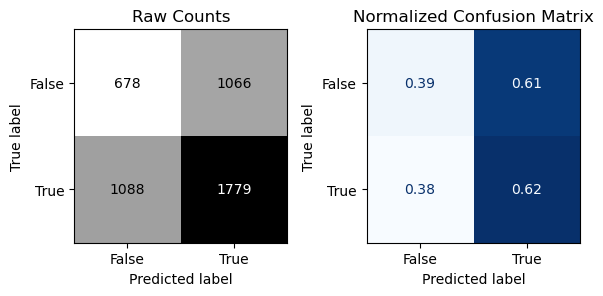


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.39      0.38      0.39       594
        True       0.62      0.63      0.62       943

    accuracy                           0.53      1537
   macro avg       0.50      0.50      0.50      1537
weighted avg       0.53      0.53      0.53      1537



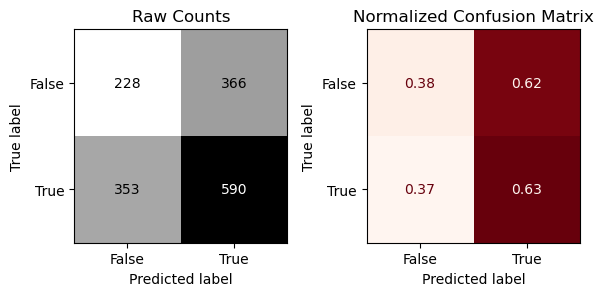

In [60]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

clf_pipe = Pipeline([('preprocessor',preprocessor),
                     ('clf',DummyClassifier(strategy='stratified'))])
clf_pipe.fit(X_train, y_train)

ds.evaluate.evaluate_classification(clf_pipe, X_train, y_train,X_test, y_test,)

> We are definitely violating the assumptions of normal residuals and homoscedasticity.

## Model# 2: Random Forest

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1744
        True       1.00      1.00      1.00      2867

    accuracy                           1.00      4611
   macro avg       1.00      1.00      1.00      4611
weighted avg       1.00      1.00      1.00      4611



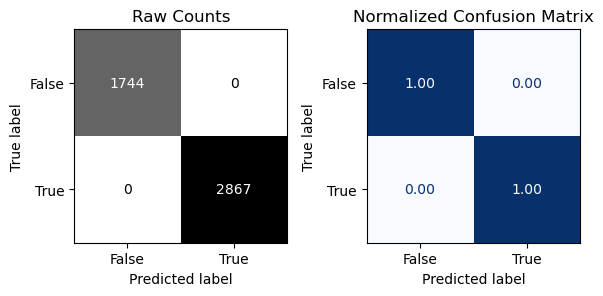


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.69      0.64      0.66       594
        True       0.78      0.82      0.80       943

    accuracy                           0.75      1537
   macro avg       0.74      0.73      0.73      1537
weighted avg       0.75      0.75      0.75      1537



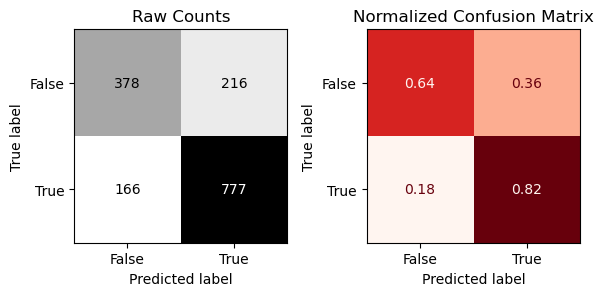

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(class_weight='balanced')
rf_pipe = Pipeline([('preprocessor',preprocessor),
                     ('clf',rf_clf)])
rf_pipe.fit(X_train, y_train)

ds.evaluate.evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

In [62]:
importances = ds.insights.get_importances(rf_pipe[-1])
importances.sort_values(ascending=False)

vote_count           0.162826
popularity           0.100784
vote_average         0.083585
runtime              0.076598
budget               0.070107
                       ...   
DayofWeek_MISSING    0.000298
MonthName_MISSING    0.000264
adult                0.000003
Genre_TV Movie       0.000000
ProdComp_MISSING     0.000000
Name: Feature Importance, Length: 107, dtype: float64

## Model 3: LogisticRegression

In [63]:
# ## Use our function to make new x,y vars
# X_train_df, y_train, X_test_df, y_test = get_train_test_split(df,add_scaler=False)
# X_train_df

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.53      0.88      0.66      1744
        True       0.88      0.53      0.66      2867

    accuracy                           0.66      4611
   macro avg       0.71      0.71      0.66      4611
weighted avg       0.75      0.66      0.66      4611



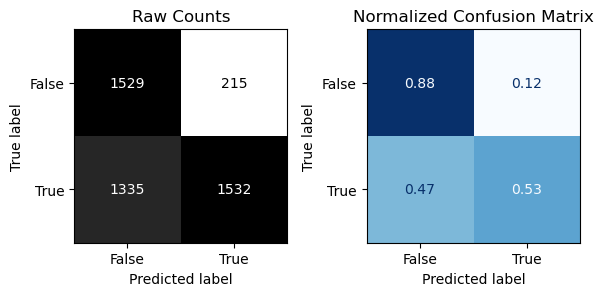


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.55      0.89      0.68       594
        True       0.88      0.54      0.67       943

    accuracy                           0.67      1537
   macro avg       0.71      0.71      0.67      1537
weighted avg       0.75      0.67      0.67      1537



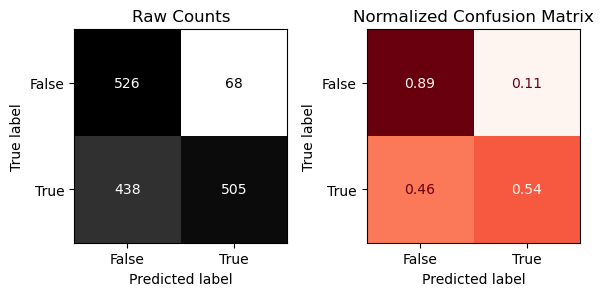

In [64]:
from sklearn.linear_model import LogisticRegressionCV

logreg_clf = LogisticRegressionCV(class_weight='balanced')
logreg_pipe = Pipeline([('preprocessor',preprocessor),
                     ('clf',logreg_clf)])
logreg_pipe.fit(X_train, y_train)

ds.evaluate.evaluate_classification(logreg_pipe,  X_train, y_train,X_test, y_test,)

#### Adding Scaling [PAUSED]

In [65]:
# from sklearn import clone

In [66]:
# preprocessor_scaled = clone(preprocessor)
# preprocessor_scaled

In [67]:
# steps = preprocessor_scaled.transformers[0]
# type(steps)

In [69]:
# steps


In [70]:
# ## Use our function to make new x,y vars
# X_train_df, y_train, X_test_df, y_test = get_train_test_split(df,add_scaler=True)
# X_train_df

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.53      0.88      0.66      1744
        True       0.88      0.53      0.66      2867

    accuracy                           0.66      4611
   macro avg       0.71      0.71      0.66      4611
weighted avg       0.75      0.66      0.66      4611



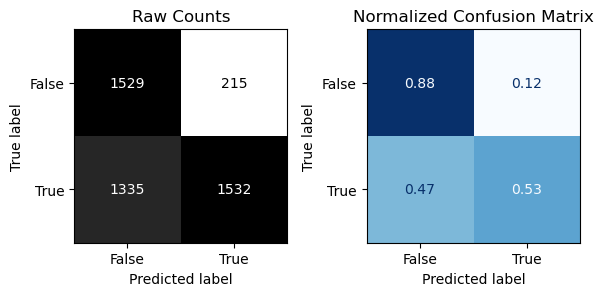


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.55      0.89      0.68       594
        True       0.88      0.54      0.67       943

    accuracy                           0.67      1537
   macro avg       0.71      0.71      0.67      1537
weighted avg       0.75      0.67      0.67      1537



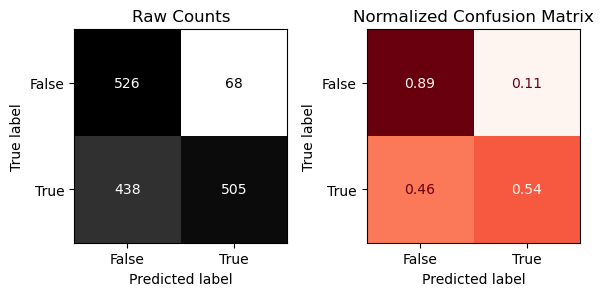

In [71]:
logreg_cv_clf = LogisticRegressionCV(max_iter=200, class_weight='balanced')
logreg_cv_pipe = Pipeline([('preprocessor',preprocessor),
                     ('clf',logreg_cv_clf)])
logreg_cv_pipe.fit(X_train, y_train)
ds.evaluate.evaluate_classification(logreg_cv_pipe,  X_train, y_train,X_test, y_test,)

# APPENDIX: Updating Code Below

- Reference for manipulating pipelines post-creation: [Jessica Miles NLP Project](https://github.com/jess-miles/nlp-sentiment/blob/main/colab_gridsearch.ipynb)

# Model Insights

### Built-In Importances

- Figure saved as Images/rf_clf_importance.png


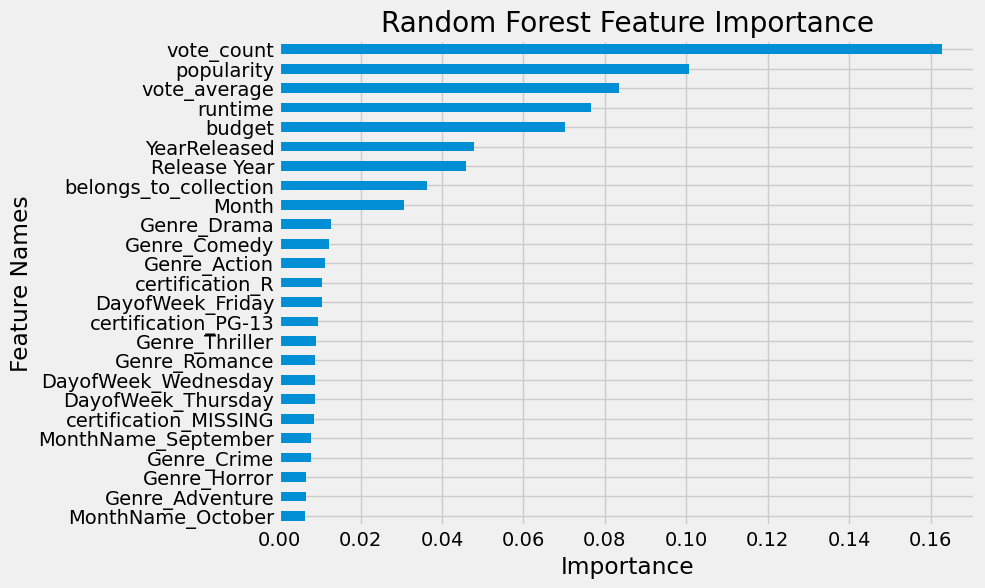

In [72]:
importances = ds.insights.get_importances(rf_pipe[-1])

with plt.style.context('fivethirtyeight'):
    ax = ds.insights.plot_importance(importances,top_n=25)
    ax.set_title('Random Forest Feature Importance')
    pf.savefig('Images/rf_clf_importance.png',ax=ax, facecolor='white')

In [73]:
# importances = pd.Series(rf_clf.feature_importances_, index=X_train_df.columns)
# ax = importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))
# ax.set_title('Random Forest Feature Importance')
# pf.savefig('Images/rf_clf_importance.png',ax=ax, facecolor='white')

### Permutation Importance

> Permutation Importances will iteratively shuffle the rows of a single feature at a time to asses the model's change in performance with that feature's relationship with the target disrupted. 
- https://scikit-learn.org/stable/modules/permutation_importance.html

```python
from sklearn.inspection import permutation_importance
r = permutation_importance(svc_linear, X_test_df, y_test, n_repeats=30)
r.keys()
```
- Interesting Observation: 
    - permutation_importance takes a `scoring` argument!

> "**Warning Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model.** Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model."

In [74]:
from sklearn.inspection import permutation_importance

### From Pipeline

In [75]:
## Permutation importance takes a fit mode and test data. 
r = permutation_importance(rf_pipe, X_test, y_test,
                           n_repeats=30)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [76]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test.columns,
                           name = 'permutation importance')
permutation_importances

adult                                 0.000000
belongs_to_collection                 0.022251
budget                                0.018478
popularity                            0.009824
runtime                               0.014877
                                        ...   
ProdComp_Village Roadshow Pictures   -0.000022
ProdComp_Walt Disney Pictures        -0.000586
ProdComp_Warner Bros. Pictures       -0.001518
ProdComp_Wild Bunch                  -0.000108
ProdComp_Working Title Films          0.000022
Name: permutation importance, Length: 82, dtype: float64

In [77]:
len(X_train.columns)

82

- Figure saved as Images/clf_permutation_importance.png


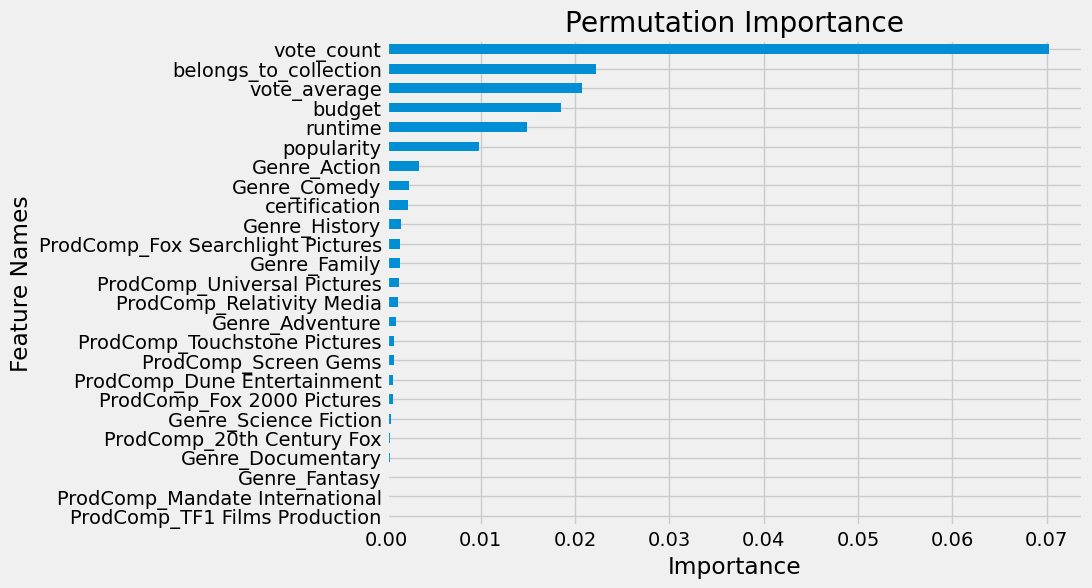

In [78]:
# ax = permutation_importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))
with plt.style.context('fivethirtyeight'):
    
    ax = ds.insights.plot_importance(permutation_importances,top_n=25)
    ax.set_title('Permutation Importance')
    pf.savefig('Images/clf_permutation_importance.png',ax=ax,facecolor='white')

### From Transformed Features

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1744
        True       1.00      1.00      1.00      2867

    accuracy                           1.00      4611
   macro avg       1.00      1.00      1.00      4611
weighted avg       1.00      1.00      1.00      4611



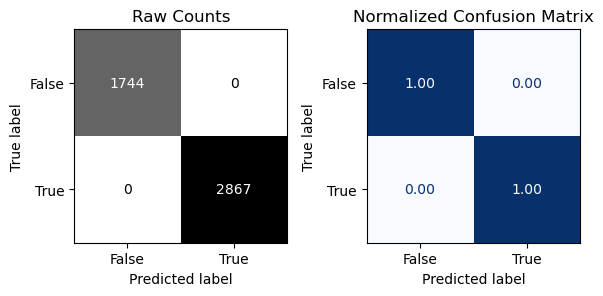


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.70      0.62      0.66       594
        True       0.78      0.83      0.80       943

    accuracy                           0.75      1537
   macro avg       0.74      0.73      0.73      1537
weighted avg       0.75      0.75      0.75      1537



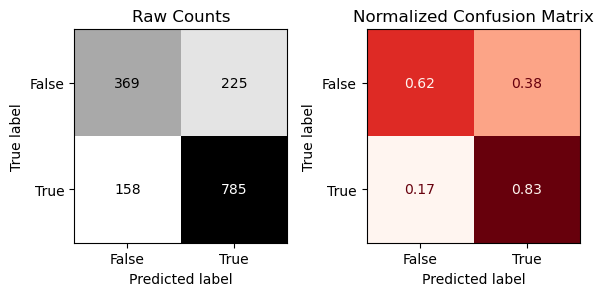

In [79]:
X_train_df = preprocessor.fit_transform(X_train)
X_test_df = preprocessor.transform(X_test)
rf_clf = RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train_df, y_train)
ds.evaluate.evaluate_classification(rf_clf, X_train_df, y_train, X_test_df, y_test)

In [80]:


## Permutation importance takes a fit mode and test data. 
r = permutation_importance(rf_clf,
                           X_test_df, y_test,
                           n_repeats=30)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [81]:
len(X_train_df.columns)

107

In [82]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_df.columns,
                           name = 'permutation importance')
permutation_importances

budget                                0.020863
popularity                            0.013771
runtime                               0.025070
vote_average                          0.027261
vote_count                            0.062936
                                        ...   
ProdComp_Village Roadshow Pictures    0.000108
ProdComp_Walt Disney Pictures        -0.000260
ProdComp_Warner Bros. Pictures       -0.001648
ProdComp_Wild Bunch                   0.000022
ProdComp_Working Title Films         -0.000043
Name: permutation importance, Length: 107, dtype: float64

- Figure saved as Images/clf_permutation_importance.png


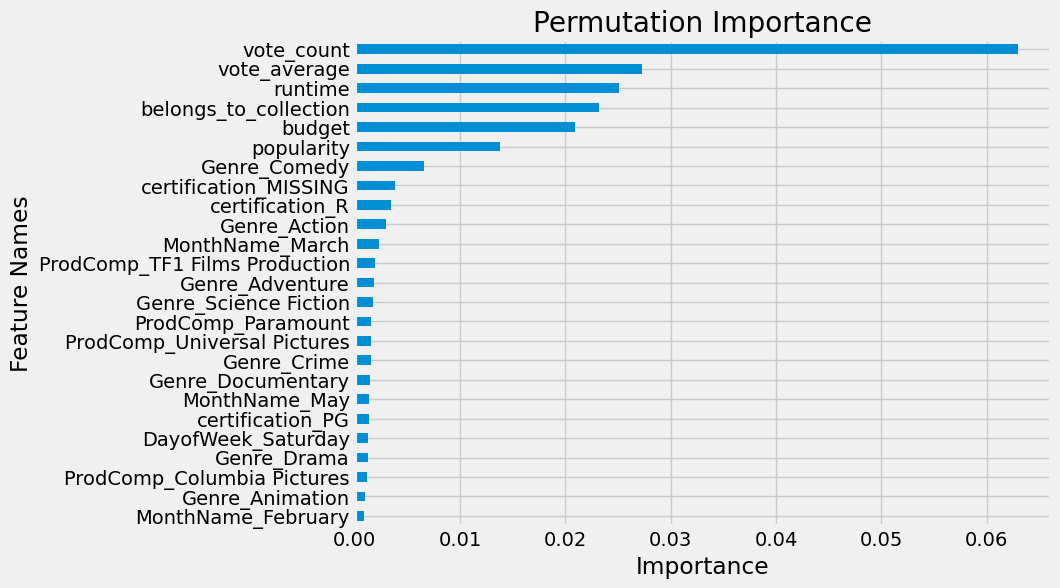

In [83]:

with plt.style.context('fivethirtyeight'):
    # ax = permutation_importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))
    ax = ds.insights.plot_importance(permutation_importances,top_n=25)
    ax.set_title('Permutation Importance')
    pf.savefig('Images/clf_permutation_importance.png',ax=ax,facecolor='white')

## Using SHAP and Shapely Values for Model Interpretation

>- SHAP (SHapley Additive exPlanations)) 
    - [Repository](https://github.com/slundberg/shap)
    - [Documentation](https://shap.readthedocs.io/en/latest/?badge=latest)
        - Install via pip or conda.
  

- SHAP uses game theory to calcualte Shapely values for each feature in the dataset. 
- Shapely values are calculated by iteratively testing each feature's contribution to the model by comparing the model's  performance with vs. without the feature. (The "marginal contribution" of the feature to the model's performance).



#### Papers, Book Excerpts, and  Blogs
- [White Paper on Shapely Values](https://arxiv.org/abs/1705.07874)
    
- [Intepretable Machine Learning Book - Section on SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)
    
- Towards Data Science Blog Posts:
    - [Explain Your Model with SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

    - [Explain Any Model with SHAP KernelExplaibner](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)





#### Videos/Talks:
- Explaining Machine Learning Models (in general).
    - ["Open the Black Box: an intro to Model Interpretability with LIME and SHAP](https://youtu.be/C80SQe16Rao)
- Understanding Shapely/SHAP Values:
    - [AI Simplified: SHAP Values in Machine Learning ](https://youtu.be/Tg8aPwPPJ9c)- (Intuitive Explanation)
    - [Explainable AI explained! | #4 SHAP  ](https://youtu.be/9haIOplEIGM)- (Math Calculation Explanation)


### How to Use Shap

- Uses game theory to explain feature importance and how a feature steered a model's prediction(s) by removing each feature and seeing the effect on the error.

- SHAP has:
    - `TreeExplainer`:
        - compatible with sckit learn, xgboost, Catboost
    - `KernelExplainer`:
        - compatible with "any" model
        


- See [this blog post](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) for intro to topic and how to use with trees

- For non-tree/random forest models [see this follow up post]( https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

        

### Using Shap for Regression Models
- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [84]:
import shap 
print(shap.__version__)
shap.initjs()

0.41.0


In [85]:
## Initialize an explainer with the model
explainer = shap.TreeExplainer(rf_clf)

## Calculaate shap values for test data
shap_values = explainer.shap_values(X_test_df,y_test)
len(shap_values)

2



**`shap.summary_plot`**
> - Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.


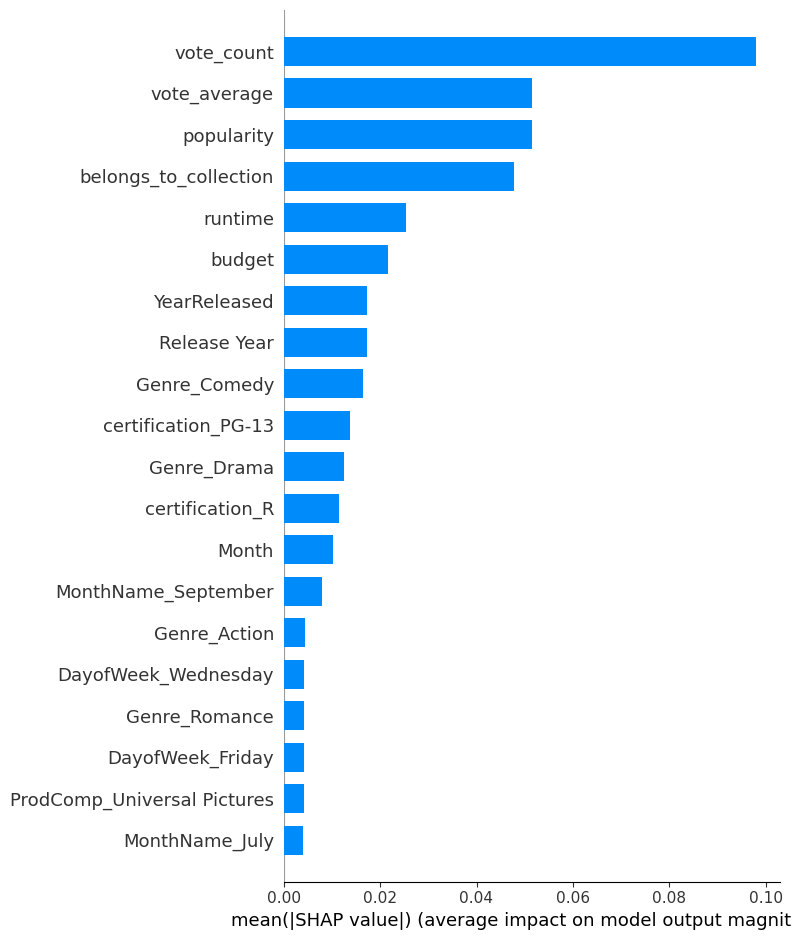

In [86]:
shap.summary_plot(shap_values[1], X_test_df,plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


- Figure saved as Images/rf_shap_summary.png


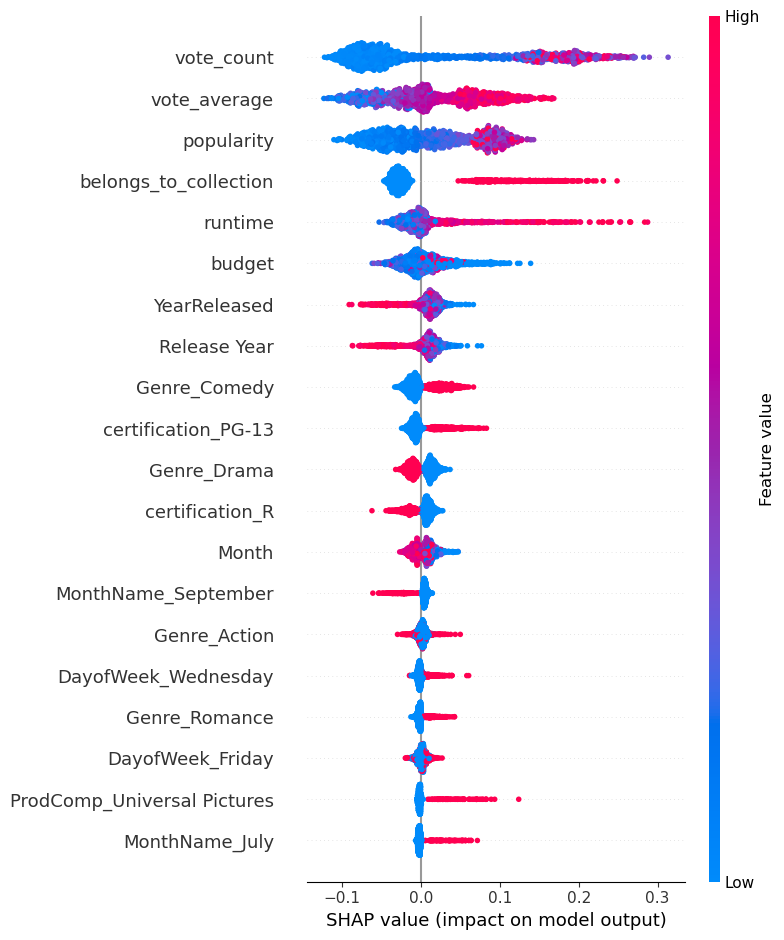

In [87]:
shap.summary_plot(shap_values[1], X_test_df,show=False)
fig = plt.gcf()
pf.savefig('Images/rf_shap_summary.png',fig=fig)

### Shap Dependence Plot

```python
## To Auto-Select Feature Most correlated with a specific feature, just pass the desired feature's column name.

shap.dependence_plot('super_dist', shap_values, X_train)

## There is a way to specifically call out multiple features but I wasn't able to summarize it quickly for this nb
```

In [88]:
# shap.dependence_plot('budget',shap_values[1],X_test_df)